In [1]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Imports & Configuration

In [2]:
# 1. Environment Setup & Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configuración del dispositivo (GPU si está disponible)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


#### Data Loading

In [3]:
ruta = "/kaggle/input/electricity-load-forecasting/continuous dataset.csv"
df = pd.read_csv(
    ruta,
    parse_dates=['datetime'],
    index_col='datetime'
).sort_index()
# Feature Engineering simple
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

# Selección de features
feature_cols = [
    'nat_demand',
    'T2M_toc', 'T2M_san', 'T2M_dav',
    'hour', 'dayofweek', 'is_weekend',
    'holiday', 'school'
]
target_col = 'nat_demand'

df_model = df[feature_cols].copy()
df_model.head()



FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/electricity-load-forecasting/continuous dataset.csv'

#### Data Preparation (Splitting & Scaling)

In [ ]:
# 3. Data Preparation
# Split Train/Test (80/20)
n = len(df_model)
train_size = int(n * 0.8)

df_train = df_model.iloc[:train_size]
df_test  = df_model.iloc[train_size:]

print(f"Train samples: {len(df_train)}")
print(f"Test samples:  {len(df_test)}")

# Scaling
# Es importante escalar fit_transform SOLO en train para evitar data leakage
X_train = df_train[feature_cols].values
y_train = df_train[[target_col]].values

X_test  = df_test[feature_cols].values
y_test  = df_test[[target_col]].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled  = scaler_X.transform(X_test)
y_test_scaled  = scaler_y.transform(y_test)

Train samples: 38438
Test samples:  9610


#### Windowing (Sliding Window)

In [ ]:
# 4. Sliding Window Creation
def create_sequences(X, y, seq_len):
    """
    Crea secuencias de entrenamiento (X) y objetivos (y).
    X: (muestras, seq_len, features)
    y: (muestras, 1)
    """
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

sequence_length = 24 * 7  # 168 horas (1 semana de historia)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  sequence_length)

# Convertir a Tensores de PyTorch
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device)

X_test_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32).to(device)
y_test_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

#### Model Architecture

In [ ]:
# 5. Model Architecture
class LSTMForecast(nn.Module): 
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)
        # Tomamos el último estado oculto
        last_hidden = out[:, -1, :]
        out = self.fc(last_hidden)
        return out

input_size = X_train_seq.shape[2]
model = LSTMForecast(input_size).to(device)
print(model)

LSTMForecast(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


#### Training Loop

In [ ]:
# 6. Training Loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 50 # Aumentado a 50 para aprovechar la GPU
print("Starting training...")

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_loss /= len(test_loader.dataset)

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}")

Starting training...
Epoch 5/50: Train Loss=0.000457, Val Loss=0.000871
Epoch 10/50: Train Loss=0.000237, Val Loss=0.000423
Epoch 15/50: Train Loss=0.000194, Val Loss=0.000291
Epoch 20/50: Train Loss=0.000181, Val Loss=0.000323
Epoch 25/50: Train Loss=0.000175, Val Loss=0.000265
Epoch 30/50: Train Loss=0.000170, Val Loss=0.000303
Epoch 35/50: Train Loss=0.000163, Val Loss=0.000294
Epoch 40/50: Train Loss=0.000162, Val Loss=0.000322
Epoch 45/50: Train Loss=0.000155, Val Loss=0.000268
Epoch 50/50: Train Loss=0.000159, Val Loss=0.000238


#### Recursive Forecast Logic

In [ ]:
# 7. Recursive Forecasting Function
def recursive_forecast_from_test(start_seq_idx, horizon=24):
    """
    Performs multi-step recursive forecasting using the test set.
    """
    # Initialize the first window
    window = X_test_seq[start_seq_idx].copy()
    
    predictions_scaled = []
    
    with torch.no_grad():
        for step in range(horizon):
            # 1. Predict the next hour
            x_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)
            y_pred = model(x_tensor)
            y_pred_val = y_pred.item()
            predictions_scaled.append(y_pred_val)
            
            # 2. Update the window for the next step (Sliding Window)
            next_window = np.zeros_like(window)
            
            # Shift everything to the left
            next_window[:-1, :] = window[1:, :]
            
            # 3. Fill the last position with new data
            # Retrieve future features (Time, Temp) from the original scaled test set
            t_index = start_seq_idx + sequence_length + step
            
            # Safety check to avoid index out of bounds
            if t_index >= len(X_test_scaled):
                break
                
            future_feat = X_test_scaled[t_index].copy()
            
            # Replace the demand feature (col 0) with our prediction
            future_feat[0] = y_pred_val
            
            # Place into the window
            next_window[-1, :] = future_feat
            
            window = next_window
            
    return np.array(predictions_scaled)

#### Results & Visualization

Performance for 48 hours horizon:
RMSE: 1160.98 MW
MAE:  24.37 MW


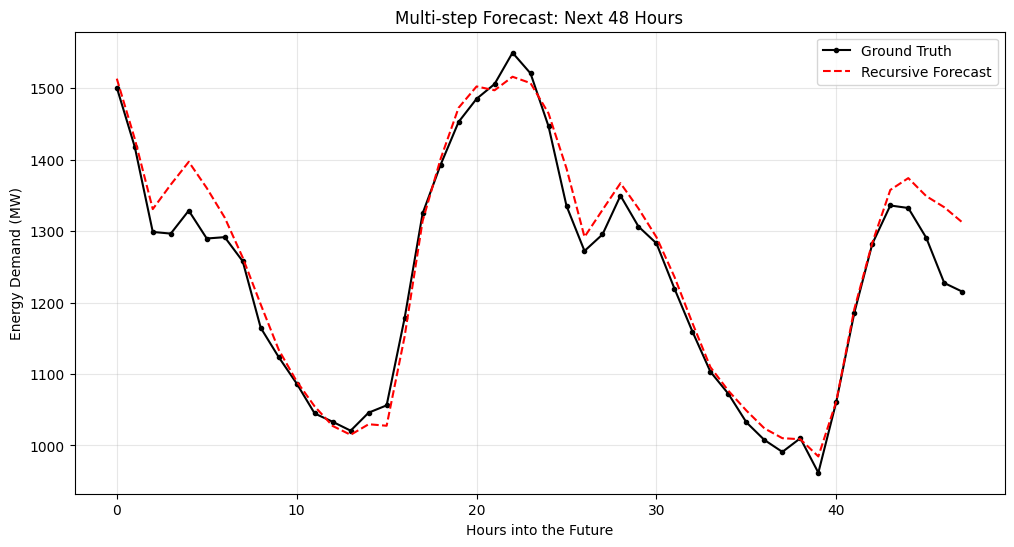

In [ ]:
# 8. Evaluation & Visualization
TEST_START_IDX = 0        # Index to start forecasting from
FORECAST_HORIZON = 48     # Hours to predict

# --- Generate Predictions ---
preds_scaled = recursive_forecast_from_test(TEST_START_IDX, horizon=FORECAST_HORIZON)
preds_mw = scaler_y.inverse_transform(preds_scaled.reshape(-1, 1))

# --- Retrieve Ground Truth ---
gt_start_idx = TEST_START_IDX + sequence_length
gt_end_idx = gt_start_idx + FORECAST_HORIZON

y_true_scaled = y_test_scaled[gt_start_idx : gt_end_idx]
y_true_mw = scaler_y.inverse_transform(y_true_scaled)

# --- Metrics ---
rmse = mean_squared_error(y_true_mw, preds_mw)
mae = mean_absolute_error(y_true_mw, preds_mw)
print(f"Performance for {FORECAST_HORIZON} hours horizon:")
print(f"RMSE: {rmse:.2f} MW")
print(f"MAE:  {mae:.2f} MW")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(y_true_mw, label='Ground Truth', marker='.', color='black')
plt.plot(preds_mw, label='Recursive Forecast', color='red', linestyle='--')
plt.title(f'Multi-step Forecast: Next {FORECAST_HORIZON} Hours')
plt.ylabel('Energy Demand (MW)')
plt.xlabel('Hours into the Future')
plt.legend()
plt.grid(True, alpha=0.3)
plt.style.use('dark_background')
plt.show()